In [157]:
# Homework 5
# Galaxy Mass Profile and Rotation Curve
# Ben Phan

In [158]:
# import modules
import numpy as np
import astropy.units as u
from astropy import constants as const
import matplotlib.pyplot as plt
import matplotlib
import sys
import os

In [159]:
# Change path to homework3 where the ReadFile.py file is
module_path = r'C:\Users\kietb\OneDrive\Desktop\Suffering\Undergrad\ASTR400B\Homeworks\Homework3'

# Add the directory to sys.path
sys.path.append(module_path)

# Import ReadFile
from ReadFile import Read

In [160]:
# Change path to homework4 where the class CenterOfMass file is
module_path = r'C:\Users\kietb\OneDrive\Desktop\Suffering\Undergrad\ASTR400B\Homeworks\Homework4'

# Add the directory to sys.path
sys.path.append(module_path)

# Import CenterOfMass class
from CenterOfMass import CenterOfMass

In [161]:
# Gravitational Constant in the desired units
# kpc * km^2 / s^2 / Msun
G = const.G.to(u.kpc * u.km**2 / u.s**2 / u.Msun)

In [162]:
class MassProfile:
    # Class to calculate the mass profiles of a given galaxy from a simulation snapshot
    def __init__(self, galaxy, snap): 
        ''' 
        Class to calculate the mass profiles of a given galaxy from a simulation snapshot. 
            
            PARAMETERS
            ----------
            galaxy : `str`
                name of the galaxy (e.g. "MW", "M31", "M33")
            snap : `int`
                snapshot number (e.g. 0, 1, etc)
        '''

        # Add a string of the filenumber to the value "000"
        ilbl = '000' + str(snap)
        
        # Remove all but the last 3 digits
        ilbl = ilbl[-3:]

        # Construct the filename
        self.filename = '%s_%s.txt' % (galaxy, ilbl)

        # Read the data from the given file
        self.time, self.total, self.data = Read(self.filename)

        # Store 3D positions
        self.x = self.data['x'] * u.kpc
        self.y = self.data['y'] * u.kpc
        self.z = self.data['z'] * u.kpc

        # Store mass (unit later)
        self.m = self.data['m']

        # Store galaxy name
        self.gname = galaxy

    def MassEnclosed(self, ptype, radius):
        ''' 
        Method to compute the mass enclosed within a given radius of the COM positionfor a specified
            component of a given galaxy. 
            
            PARAMETERS
            ----------
            ptype : `int`
                particle type of the galaxy (e.g. 1 - halo, 2 - disk, 3 - bulge)
            radius : `array`
                array of radii (in kpc) to compute the enclosed mass.
    
            RETURNS
            -------
            enclosed_mass : `astropy quantity`
                array of enclosed masses (in astropy unit solar masses) within specified radii.
        '''

        # Creating a COM object
        COM = CenterOfMass(self.filename, 2) # use disk particles to determine COM position
        COM_pos = COM.COM_P(0.1) # get the COM position within 0.1 delta

        # Extract position data for the input particle type
        index = np.where(self.data['type'] == ptype)
        x = self.x[index] - COM_pos[0] # compute the position different in x
        y = self.y[index] - COM_pos[1] # compute the position different in y
        z = self.z[index] - COM_pos[2] # compute the position different in z
        
        # Compute the separration from COM
        r = np.sqrt(x**2 + y**2 + z**2)

        # Extract mass data for the input particle type 
        m = self.m[index] * u.Msun # assign unit Msun

        # Initialize array to store enclosed mass
        enclosed_mass = np.zeros(len(radius)) * u.Msun # assign unit 1 more time so mass can be stored

        # Loop through each radius and sum all the enclosed mass within the radius
        for i in range(len(radius)):
            enclosed_mass[i] = np.sum(m[r < radius[i] * u.kpc]) * 1e10 # original data is in 1e10 Msun
        return enclosed_mass
    
    def MassEnclosedTotal(self, radius):
        '''
        Compute the total mass enclosed from all 3 components (halo, disk, and bulge).
        
        PARAMETERS
        ----------
        radius : `array`
            array of radii (in kpc) to compute the total enclosed mass.
        
        RETURNS
        -------
        total_mass : `astropy Quantity`
            array of total enclosed masses (in astropy unit solar masses) within specified radii.
        '''

        # Compute mass enclosed for each compononet (except bulge)
        halo_mass = self.MassEnclosed(1, radius)
        disk_mass = self.MassEnclosed(2, radius)

        # Check if the galaxy is M33
        if self.gname == 'M33':
            bulge_mass = np.zeros(len(radius)) * u.Msun # no bulge mass for M33
        else:
            bulge_mass = self.MassEnclosed(3, radius) # otherwise calculate the bulge mass like usual

        # Compute the total mass
        total_mass = halo_mass + disk_mass + bulge_mass

        return total_mass
    
    def HernquistMass(self, r, a, Mhalo):
        '''
        Compute the Hernquist mass enclosed within a given radius.
        
        PARAMETERS
        ----------
        r : `array`
            array of radii (in kpc) to compute the enclosed mass.
        a : `float`
            scale factor of the Hernquist profile.
        Mhalo : `float`
            total halo mass.
        
        RETURNS
        -------
        hernquist_enclosed : `array`
            array of Hernquist masses enclosed within radius r (in solar masses).
        '''
        
        # Compute the Herquist mass
        frac = r**2 / (a + r) ** 2 # fraction part of the equation
        hernquist_enclosed = Mhalo * frac

        return hernquist_enclosed

    def CircularVelocity(self, ptype, radius):
        '''
        Compute the circular velocity using the mass enclosed at each radius.

        PARAMETERS
        ----------
        ptype : `int`
            type of particle (halo, disk, or bulge).
        radius : `array`
            array of radii (in kpc) to compute the circular velocity.

        RETURNS
        -------
        Vcirc : `array`
            array of circular velocity (in km/s), rounded to 2 decimal places.
        '''

        # Get the enclosed mass
        mass_enclosed = self.MassEnclosed(ptype, radius)

        # Compute circular velocity
        # GM / r^2 = Vcirc^2 / r
        # Vcirc = sqrt(GM / r)
        # Unit is already in  km/s
        Vcirc = np.sqrt(G * mass_enclosed / radius)
        Vcirc = np.round(Vcirc, 2) * u.km / u.s # round to 2 decimal places

        return Vcirc

    def CircularVelocityTotal(self, radius):
        '''
        Compute the total circular velocity created by all the galaxy components.
        
        PARAMETERS
        ----------
        radius : `array`
            array of radii (in kpc) to compute the circular velocity.
        
        RETURNS
        -------
        Vcirc_total : `array`
            total circular velocity (in km/s) created by all the galaxy components (halo + disk + bulge)
            at each radius of the input array, rounded to 2 decimal places.
        '''

        # Get the total enclosed mass
        mass_enclosed_total = self.MassEnclosedTotal(radius)

        # Compute total circular velocity
        Vcirc_total = np.sqrt(G * mass_enclosed_total / radius)
        # Not required but I also rounded Vcirc_total to 2 decimal places for consistency
        Vcirc_total = np.round(Vcirc_total, 2) * u.km / u.s
        return Vcirc_total

    def HernquistVCirc(self, radius, a, Mhalo):
        '''
        Compute the circular velocity using Hernquist mass profile.
        
        PARAMETERS
        ----------
        r : `array`
            array of radii (in kpc) to compute the enclosed mass.
        a : `float`
            scale factor of the Hernquist profile.
        Mhalo : `float`
            total halo mass.
        
        RETURNS
        -------
        Vcirc_hernquist : `array`
            array of circular velocity (in km/s) computed by using Hernquist mass profile, rounded to 2 decimal places.
        '''
            
        # Compute the Hernquist enclosed mass
        mass_enclosed_hernquist = self.HernquistMass(radius, a, Mhalo)

        # Compute total circular velocity
        Vcirc_hernquist = np.sqrt(G * mass_enclosed_hernquist / radius)
        Vcirc_hernquist = np.round(Vcirc_hernquist, 2) * u.km / u.s # convert circular velocity to km/s
        return Vcirc_hernquist

In [163]:
# Test cell

# initialize the MassProfile class for MW
MW = MassProfile(r"C:\Users\kietb\OneDrive\Desktop\Suffering\Undergrad\ASTR400B\Homeworks\Homework3\MW", 0)

# create an array of radii as the input
r = np.arange(0.25, 30.5, 1.5); print(r) 

# get the enclosed halo masses at each element in 'r'
MW.MassEnclosed(1, r)

[ 0.25  1.75  3.25  4.75  6.25  7.75  9.25 10.75 12.25 13.75 15.25 16.75
 18.25 19.75 21.25 22.75 24.25 25.75 27.25 28.75 30.25]
CHANGE =  0.22978104414074885
maxR 11.020481333398111


<Quantity [0.00000000e+00, 1.10595800e+09, 4.34483500e+09, 9.08465500e+09,
           1.59968925e+10, 2.39360910e+10, 3.15198030e+10, 4.10784400e+10,
           5.35599660e+10, 6.35925850e+10, 7.56001290e+10, 8.81606520e+10,
           1.01866632e+11, 1.16165088e+11, 1.29792071e+11, 1.44762002e+11,
           1.59534442e+11, 1.73516910e+11, 1.86274926e+11, 1.99072440e+11,
           2.13331398e+11] solMass>

CHANGE =  0.22978104414074885
maxR 11.020481333398111
CHANGE =  0.22978104414074885
maxR 11.020481333398111
CHANGE =  0.22978104414074885
maxR 11.020481333398111
CHANGE =  0.22978104414074885
maxR 11.020481333398111
CHANGE =  0.22978104414074885
maxR 11.020481333398111
CHANGE =  0.22978104414074885
maxR 11.020481333398111


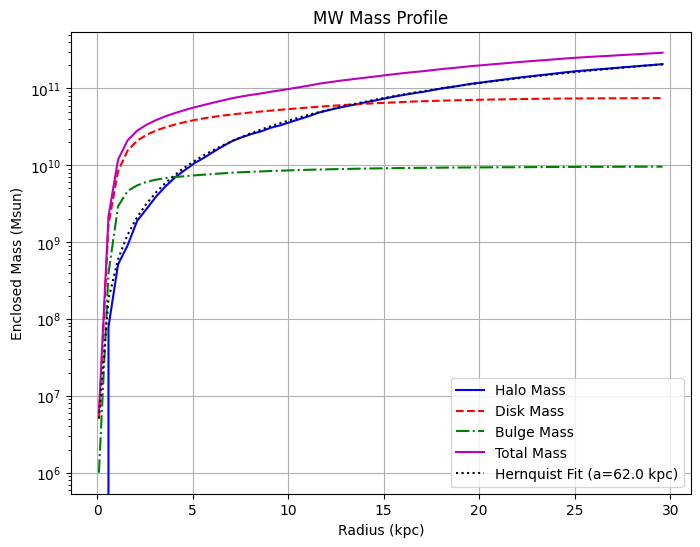

<Figure size 640x480 with 0 Axes>

In [164]:
# Compute the mass profile for MW
MW = MassProfile(r"C:\Users\kietb\OneDrive\Desktop\Suffering\Undergrad\ASTR400B\Homeworks\Homework3\MW", 0)

# Define radii array from 0.1 to 30 kpc
radii = np.arange(0.1, 30, 0.5)

# Compute enclosed mass for each galaxy component
halo_mass = MW.MassEnclosed(1, radii)
disk_mass = MW.MassEnclosed(2, radii)
bulge_mass = MW.MassEnclosed(3, radii)

# Compute enclosed mass for all components
total_mass = MW.MassEnclosedTotal(radii)

# Compute Mhalo
# Mhalo from homework 3
Mhalo = 1.975 * 1e12 * u.Msun

# Fit Hernquist profile
best_a = 62.0 # in kpc, guess value at the moment
hernquist_mass = MW.HernquistMass(radii, best_a, Mhalo)

# Plot the mass profiles for MW
plt.figure(figsize = (8, 6))
plt.semilogy(radii, halo_mass, 'b-', label = 'Halo Mass')
plt.semilogy(radii, disk_mass, 'r--', label = 'Disk Mass')
plt.semilogy(radii, bulge_mass, 'g-.', label = 'Bulge Mass')
plt.semilogy(radii, total_mass, 'm-', label = 'Total Mass')
plt.semilogy(radii, hernquist_mass, 'k:', label = f'Hernquist Fit (a={best_a} kpc)')

# Labels
plt.xlabel('Radius (kpc)')
plt.ylabel('Enclosed Mass (Msun)')
plt.title('MW Mass Profile')
plt.legend()
plt.grid()

# Show the plot
plt.show()

# Save the plot as a PDF
plt.savefig("MW_Mass_Profile.pdf", format="pdf")

CHANGE =  0.04459429679900495
maxR 16.68229943877858
CHANGE =  0.04459429679900495
maxR 16.68229943877858
CHANGE =  0.04459429679900495
maxR 16.68229943877858
CHANGE =  0.04459429679900495
maxR 16.68229943877858
CHANGE =  0.04459429679900495
maxR 16.68229943877858
CHANGE =  0.04459429679900495
maxR 16.68229943877858


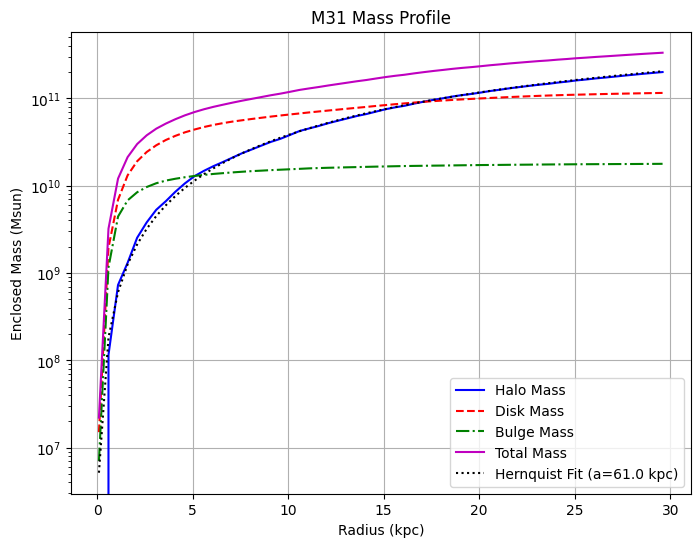

<Figure size 640x480 with 0 Axes>

In [ ]:
# Compute the mass profile for M31
M31 = MassProfile(r"C:\Users\kietb\OneDrive\Desktop\Suffering\Undergrad\ASTR400B\Homeworks\Homework3\M31", 0)

# Define radii array from 0.1 to 30 kpc
radii = np.arange(0.1, 30, 0.5)

# Compute enclosed mass for each galaxy component
halo_mass = M31.MassEnclosed(1, radii)
disk_mass = M31.MassEnclosed(2, radii)
bulge_mass = M31.MassEnclosed(3, radii)

# Compute enclosed mass for all components
total_mass = M31.MassEnclosedTotal(radii)

# Compute Mhalo
# Mhalo from homework 3
Mhalo = 1.921 * 1e12 * u.Msun

# Fit Hernquist profile
best_a = 61.0 # guess value at the moment
hernquist_mass = M31.HernquistMass(radii, best_a, Mhalo)

# Plot the mass profiles for MW
plt.figure(figsize = (8, 6))
plt.semilogy(radii, halo_mass, 'b-', label = 'Halo Mass')
plt.semilogy(radii, disk_mass, 'r--', label = 'Disk Mass')
plt.semilogy(radii, bulge_mass, 'g-.', label = 'Bulge Mass')
plt.semilogy(radii, total_mass, 'm-', label = 'Total Mass')
plt.semilogy(radii, hernquist_mass, 'k:', label = f'Hernquist Fit (a={best_a} kpc)')

# Labels
plt.xlabel('Radius (kpc)')
plt.ylabel('Enclosed Mass (Msun)')
plt.title('M31 Mass Profile')
plt.legend()
plt.grid()

# Show the plot
plt.show()

# Save the plot as a PDF
plt.savefig("M31_Mass_Profile.pdf", format="pdf")

CHANGE =  0.01308865872044862
maxR 3.9330197268235163
CHANGE =  0.01308865872044862
maxR 3.9330197268235163
CHANGE =  0.01308865872044862
maxR 3.9330197268235163
CHANGE =  0.01308865872044862
maxR 3.9330197268235163
CHANGE =  0.01308865872044862
maxR 3.9330197268235163
CHANGE =  0.01308865872044862
maxR 3.9330197268235163


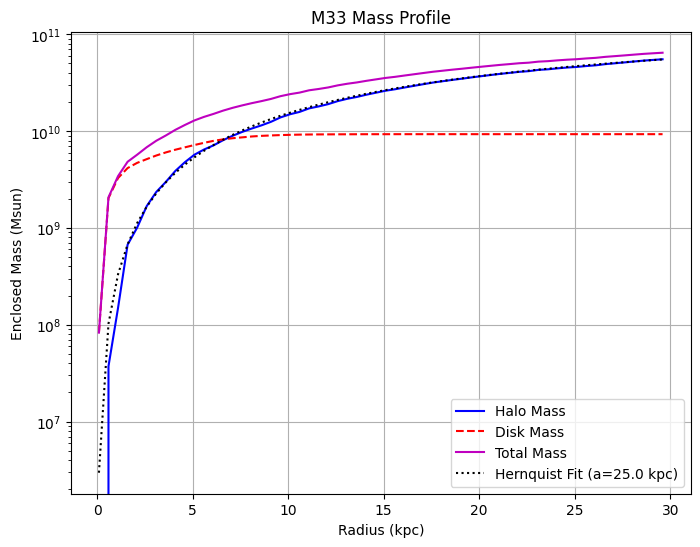

<Figure size 640x480 with 0 Axes>

In [166]:
# Compute the mass profile for M33
M33 = MassProfile(r"C:\Users\kietb\OneDrive\Desktop\Suffering\Undergrad\ASTR400B\Homeworks\Homework3\M33", 0)

# Define radii array from 0.1 to 30 kpc
radii = np.arange(0.1, 30, 0.5)

# Compute enclosed mass for each galaxy component
halo_mass = M33.MassEnclosed(1, radii)
disk_mass = M33.MassEnclosed(2, radii)
bulge_mass = M33.MassEnclosed(3, radii)

# Compute enclosed mass for all components
total_mass = M33.MassEnclosedTotal(radii)

# Compute Mhalo
# Mhalo from homework 3
Mhalo = 0.187 * 1e12 * u.Msun

# Fit Hernquist profile
best_a = 25.0 # guess value at the moment
hernquist_mass = M33.HernquistMass(radii, best_a, Mhalo)

# Plot the mass profiles for MW
plt.figure(figsize = (8, 6))
plt.semilogy(radii, halo_mass, 'b-', label = 'Halo Mass')
plt.semilogy(radii, disk_mass, 'r--', label = 'Disk Mass')
plt.semilogy(radii, total_mass, 'm-', label = 'Total Mass')
plt.semilogy(radii, hernquist_mass, 'k:', label = f'Hernquist Fit (a={best_a} kpc)')

# Labels
plt.xlabel('Radius (kpc)')
plt.ylabel('Enclosed Mass (Msun)')
plt.title('M33 Mass Profile')
plt.legend()
plt.grid()

# Show the plot
plt.show()

# Save the plot as a PDF
plt.savefig("M33_Mass_Profile.pdf", format="pdf")

CHANGE =  0.22978104414074885
maxR 11.020481333398111
CHANGE =  0.22978104414074885
maxR 11.020481333398111
CHANGE =  0.22978104414074885
maxR 11.020481333398111
CHANGE =  0.22978104414074885
maxR 11.020481333398111
CHANGE =  0.22978104414074885
maxR 11.020481333398111
CHANGE =  0.22978104414074885
maxR 11.020481333398111


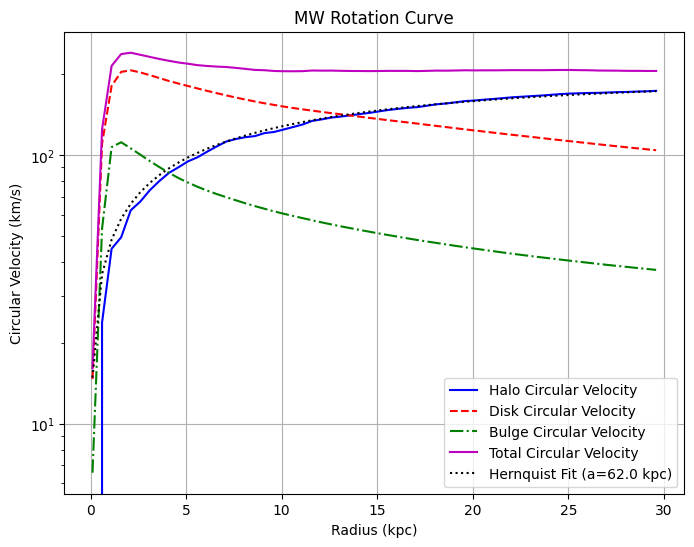

<Figure size 640x480 with 0 Axes>

In [167]:
# Compute the mass profile for MW
MW = MassProfile(r"C:\Users\kietb\OneDrive\Desktop\Suffering\Undergrad\ASTR400B\Homeworks\Homework3\MW", 0)

# Define radii from 0.1 to 30 kpc
radii = np.arange(0.1, 30.1, 0.5)

# Compute circular velocities for all components
halo_vcirc = MW.CircularVelocity(1, radii)
disk_vcirc = MW.CircularVelocity(2, radii)
bulge_vcirc = MW.CircularVelocity(3, radii)
total_vcirc = MW.CircularVelocityTotal(radii)

# Compute Mhalo
# Mhalo from homework 3
Mhalo = 1.975 * 1e12 * u.Msun

# Fit Hernquist profile
best_a = 62.0 # guess value at the moment
hernquist_vcirc = MW.HernquistVCirc(radii, best_a, Mhalo)

# Plot rotation curve
plt.figure(figsize = (8, 6))
plt.semilogy(radii, halo_vcirc, 'b-', label = 'Halo Circular Velocity')
plt.semilogy(radii, disk_vcirc, 'r--', label = 'Disk Circular Velocity')
plt.semilogy(radii, bulge_vcirc, 'g-.', label = 'Bulge Circular Velocity')
plt.semilogy(radii, total_vcirc, 'm-', label = 'Total Circular Velocity')
plt.semilogy(radii, hernquist_vcirc, 'k:', label = f'Hernquist Fit (a={best_a} kpc)')

# Labels and Legends
plt.xlabel("Radius (kpc)")
plt.ylabel("Circular Velocity (km/s)")
plt.title("MW Rotation Curve")
plt.legend()
plt.grid()

# Show the plot
plt.show()

# Save the plot as a PDF
plt.savefig("MW_Rotation_Curve.pdf", format="pdf")

CHANGE =  0.04459429679900495
maxR 16.68229943877858
CHANGE =  0.04459429679900495
maxR 16.68229943877858
CHANGE =  0.04459429679900495
maxR 16.68229943877858
CHANGE =  0.04459429679900495
maxR 16.68229943877858
CHANGE =  0.04459429679900495
maxR 16.68229943877858
CHANGE =  0.04459429679900495
maxR 16.68229943877858


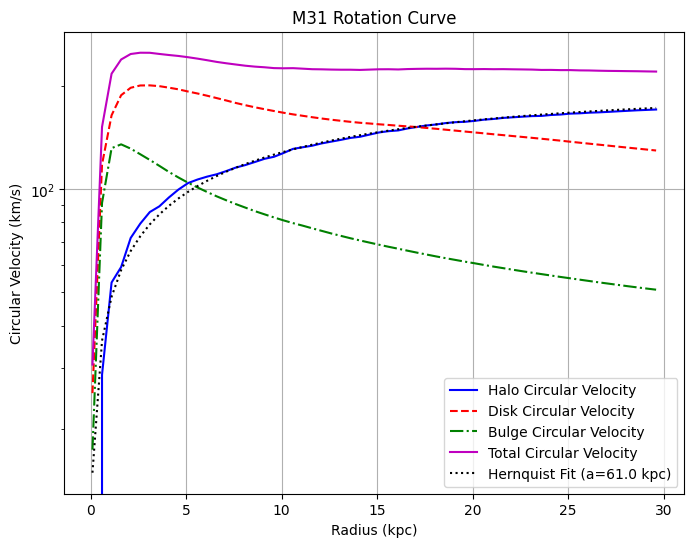

<Figure size 640x480 with 0 Axes>

In [168]:
# Compute the mass profile for M31
M31 = MassProfile(r"C:\Users\kietb\OneDrive\Desktop\Suffering\Undergrad\ASTR400B\Homeworks\Homework3\M31", 0)

# Define radii from 0.1 to 30 kpc
radii = np.arange(0.1, 30.1, 0.5)

# Compute circular velocities for all components
halo_vcirc = M31.CircularVelocity(1, radii)
disk_vcirc = M31.CircularVelocity(2, radii)
bulge_vcirc = M31.CircularVelocity(3, radii)
total_vcirc = M31.CircularVelocityTotal(radii)

# Compute Mhalo
# Mhalo from homework 3
Mhalo = 1.921 * 1e12 * u.Msun

# Fit Hernquist profile
best_a = 61.0 # guess value at the moment
hernquist_vcirc = M31.HernquistVCirc(radii, best_a, Mhalo)

# Plot rotation curve
plt.figure(figsize = (8, 6))
plt.semilogy(radii, halo_vcirc, 'b-', label = 'Halo Circular Velocity')
plt.semilogy(radii, disk_vcirc, 'r--', label = 'Disk Circular Velocity')
plt.semilogy(radii, bulge_vcirc, 'g-.', label = 'Bulge Circular Velocity')
plt.semilogy(radii, total_vcirc, 'm-', label = 'Total Circular Velocity')
plt.semilogy(radii, hernquist_vcirc, 'k:', label = f'Hernquist Fit (a={best_a} kpc)')

# Labels and Legends
plt.xlabel("Radius (kpc)")
plt.ylabel("Circular Velocity (km/s)")
plt.title("M31 Rotation Curve")
plt.legend()
plt.grid()

# Show the plot
plt.show()

# Save the plot as a PDF
plt.savefig("M31_Rotation_Curve.pdf", format="pdf")

CHANGE =  0.01308865872044862
maxR 3.9330197268235163
CHANGE =  0.01308865872044862
maxR 3.9330197268235163
CHANGE =  0.01308865872044862
maxR 3.9330197268235163
CHANGE =  0.01308865872044862
maxR 3.9330197268235163
CHANGE =  0.01308865872044862
maxR 3.9330197268235163
CHANGE =  0.01308865872044862
maxR 3.9330197268235163


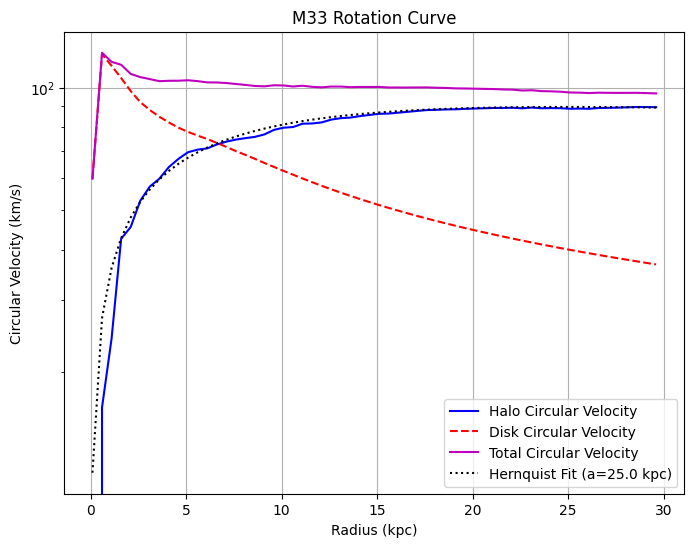

<Figure size 640x480 with 0 Axes>

In [171]:
# Compute the mass profile for M33
M33 = MassProfile(r"C:\Users\kietb\OneDrive\Desktop\Suffering\Undergrad\ASTR400B\Homeworks\Homework3\M33", 0)

# Define radii from 0.1 to 30 kpc
radii = np.arange(0.1, 30.1, 0.5)

# Compute circular velocities for all components
halo_vcirc = M33.CircularVelocity(1, radii)
disk_vcirc = M33.CircularVelocity(2, radii)
bulge_vcirc = M33.CircularVelocity(3, radii)
total_vcirc = M33.CircularVelocityTotal(radii)

# Compute Mhalo
# Mhalo from homework 3
Mhalo = 0.187 * 1e12 * u.Msun

# Fit Hernquist profile
best_a = 25.0 # guess value at the moment
hernquist_vcirc = M33.HernquistVCirc(radii, best_a, Mhalo)

# Plot rotation curve
plt.figure(figsize = (8, 6))
plt.semilogy(radii, halo_vcirc, 'b-', label = 'Halo Circular Velocity')
plt.semilogy(radii, disk_vcirc, 'r--', label = 'Disk Circular Velocity')
plt.semilogy(radii, total_vcirc, 'm-', label = 'Total Circular Velocity')
plt.semilogy(radii, hernquist_vcirc, 'k:', label = f'Hernquist Fit (a={best_a} kpc)')

# Labels and Legends
plt.xlabel("Radius (kpc)")
plt.ylabel("Circular Velocity (km/s)")
plt.title("M33 Rotation Curve")
plt.legend()
plt.grid()

# Show the plot
plt.show()

# Save the plot as a PDF
plt.savefig("M33_Rotation_Curve.pdf", format="pdf")